In [1]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.random.uniform(low=-1, high=1, size=(200,2))
y = np.ones(len(X))

y[X[:,0]*X[:,1]<0] = 0
# another way to do the same thing as above
# for i in range(len(X)):
#     if X[i,0] * X[i,1] < 0:
#         y[i] = 0

n_train = 100

X_train = torch.from_numpy(X[:n_train, :]).to(dtype=torch.float32)
y_train = torch.from_numpy(y[:n_train]).to(dtype=torch.float32)

X_valid = torch.from_numpy(X[n_train:, :]).to(dtype=torch.float32)
y_valid = torch.from_numpy(y[n_train:]).to(dtype=torch.float32)

In [3]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, y_train)

batch_size = 2
torch.manual_seed(42)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [4]:
import torch
import torch.nn as nn 

class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddiv=0.1):
        super().__init__()
        # initializing weights
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        #initializing bias
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddiv = noise_stddiv

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddiv, x.shape)
            x_new = torch.add(x,noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In [5]:
torch.manual_seed(42)
noisy_layer = NoisyLinear(4,2)
x = torch.zeros((1,4))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=False))

tensor([[-0.0988, -0.1032]], grad_fn=<AddBackward0>)
tensor([[-0.0221,  0.1212]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [6]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = NoisyLinear(2,4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4,4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4,1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x 
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        preds = self.forward(x).squeeze()
        return (preds>=0.5).float()
    
torch.manual_seed(42)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [7]:
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

Text(0.5, 0, '$x_1$')

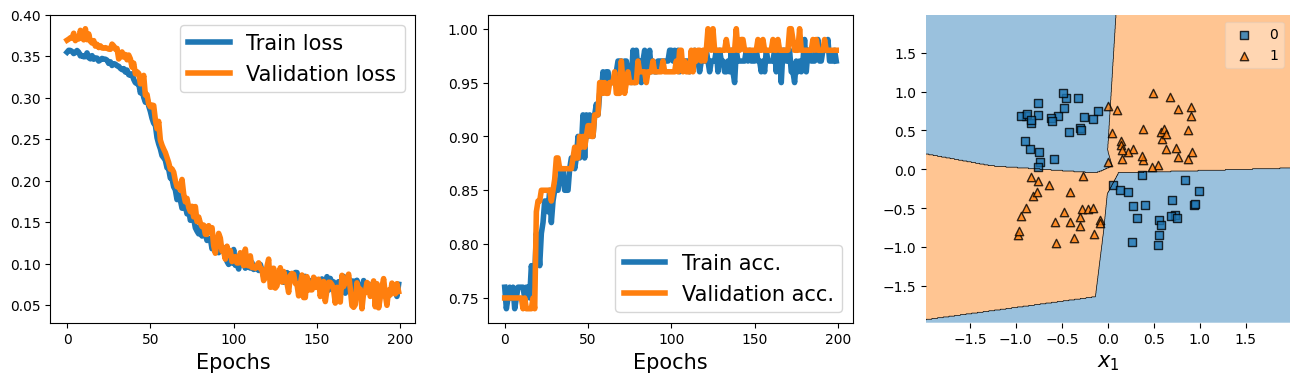

In [13]:
torch.manual_seed(42)
num_epoch = 200

# saving loss and accuracy
loss_hist_train = [0] * num_epoch
train_acc = [0] * num_epoch
loss_hist_valid = [0] * num_epoch
valid_acc = [0] * num_epoch

for epoch in range(num_epoch):
    for x_batch, y_batch in train_dl:
        preds = model(x_batch).squeeze()
        loss = loss_func(preds, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist_train[epoch] += loss.item()
        is_correct = (
            (preds>=0.5).float() == y_batch
        ).float()
        train_acc[epoch] += is_correct.mean()
    
    loss_hist_train[epoch] /= len(train_dl)
    train_acc[epoch] /= len(train_dl)

    preds = model(X_valid).squeeze()
    loss = loss_func(preds, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((preds>=0.5).float() == y_valid).float()
    valid_acc[epoch] += is_correct.mean()



from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(train_acc, lw=4)
plt.plot(valid_acc, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=X_valid.numpy(),
                      y=y_valid.numpy().astype(np.int_),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)

In [23]:
acc = valid_acc[199] * 100
print(acc)

tensor(98.)
